<a href="https://colab.research.google.com/github/Syilun/Kaggle/blob/main/semiconductor_test_result_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task for Today  

***

## Semiconductor Test Result Prediction  
  
Given *data about semiconductors*, let's try to predict whether a given semiconductor will **pass or fail** a QA test.  
  
We will use a logistic regression model to make our predictions.

# Getting Started

In [3]:
from google.colab import drive # Import a library named google.colab
drive.mount('/content/drive', force_remount=True) # mount the content to the directory `/content/drive`

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/secom/ 
#change directory to secom folder in google drive
!pwd #output the current directory
!ls

/content/drive/MyDrive/secom
/content/drive/MyDrive/secom
uci-secom.csv


In [5]:
import torch
torch.cuda.is_available() # is GPU available
# Outputs True if running with GPU

True

In [6]:
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings(action='ignore')

In [9]:
data = pd.read_csv('../secom/uci-secom.csv')

In [10]:
data

,Time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0.0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,...,0.78,0.1827,5.7349,0.3363,39.8842,3.2687,1.0297,1.0344,0.4385,0.1039,42.3877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,NaN,NaN,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,-0.0148,0.9627,200.5470,0.0,10.1548,414.7347,9.2599,0.9701,191.2872,12.4608,1.3825,-5441.50,2604.25,-3498.75,-1640.25,1.2973,2.0143,7.3900,68.4222,2.2667,0.2102,3.4171,84.9052,9.7997,50.6596,64.2828,49.3404,64.9193,87.5241,...,1.33,0.2829,7.1196,0.4989,53.1836,3.9139,1.7819,0.9634,0.1745,0.0375,18.1087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0.0096,0.0201,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,0.0013,0.9615,202.0179,0.0,9.5157,416.7075,9.3144,0.9674,192.7035,12.5404,1.4123,-5447.75,2701.75,-4047.00,-1916.50,1.3122,2.0295,7.5788,67.1333,2.3333,0.1734,3.5986,84.7569,8.6590,50.1530,64.1114,49.8470,65.8389,84.7327,...,0.85,0.0857,7.1619,0.3752,23.0713,3.9306,1.1386,1.5021,0.3718,0.1233,24.7524,267.064,0.9032,1.10,0.6219,0.4122,0.2562,0.4119,68.8489,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,0.0584,0.0484,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,-0.0033,0.9629,201.8482,0.0,9.6052,422.2894,9.6924,0.9687,192.1557,12.4782,1.4011,-5468.25,2648.25,-4515.00,-1657.25,1.3137,2.0038,7.3145,62.9333,2.6444,0.2071,3.3813,84.9105,8.6789,50.5100,64.1125,49.4900,65.1951,86.6867,...,39.33,0.6812,56.9303,17.4781,161.4081,35.3198,54.2917,1.1613,0.7288,0.2710,62.7572,268.228,0.6511,7.32,0.1630,3.5611,0.0670,2.7290,25.0363,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0.0202,0.0149,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,-0.0072,0.9569,201.9424,0.0,10.5661,420.5925,10.3387,0.9735,191.6037,12.4735,1.3888,-5476.25,2635.25,-3987.50,117.00,1.2887,1.9912,7.2748,62.8333,3.1556,0.2696,3.2728,86.3269,8.7677,50.2480,64.1511,49.7520,66.1542,86.1468,...,1.98,0.4287,9.7608,0.8311,70.9706,4.9086,2.5014,0.9778,0.2156,0.0461,22.0500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,NaN,NaN,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2008-10-16 15:13:00,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,-0.0045,-0.0057,0.9579,203.9867,0.0,11.7692,419.3404,10.2397,0.9693,193.7470,12.5373,1.4072,-5418.75,2608.00,-6228.25,356.00,1.2817,1.9540,7.0793,71.1444,2.2222,0.1753,3.4680,83.8405,8.7164,50.2482,64.3573,49.7518,66.2013,86.3672,...,0.80,0.4754,8.5138,0.3141,85.1806,4.2063,1.0367,1.0972,0.3553,0.0929,32.3812,264.272,0.5671,4.98,0.0877,2.0902,0.0382,1.8844,15.4662,5

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


# Preprocessing

In [12]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop Time
    df = df.drop('Time', axis=1)
    
    # Drop columns with more than 25% missing values
    missing_value_columns = df.columns[df.isna().mean() >= 0.25]
    df = df.drop(missing_value_columns, axis=1)
    
    # Fill remaining missing values
    for column in df.columns:
        df[column] = df[column].fillna(df[column].mean())
    
    # Remove columns with only one value
    single_value_columns = [
        '5', '13', '42', '49', '52', '69', '97', '141', '149', '178', '179', '186', '189', '190',
        '191', '192', '193', '194', '226', '229', '230', '231', '232', '233', '234', '235', '236',
        '237', '240', '241', '242', '243', '256', '257', '258', '259', '260', '261', '262', '263',
        '264', '265', '266', '276', '284', '313', '314', '315', '322', '325', '326', '327', '328',
        '329', '330', '364', '369', '370', '371', '372', '373', '374', '375', '378', '379', '380',
        '381', '394', '395', '396', '397', '398', '399', '400', '401', '402', '403', '404', '414',
        '422', '449', '450', '451', '458', '461', '462', '463', '464', '465', '466', '481', '498',
        '501', '502', '503', '504', '505', '506', '507', '508', '509', '512', '513', '514', '515',
        '528', '529', '530', '531', '532', '533', '534', '535', '536', '537', '538'
    ]
    df = df.drop(single_value_columns, axis=1)
    
    # Give text labels to the training examples
    df['Pass/Fail'] = df['Pass/Fail'].replace({-1: "PASS", 1: "FAIL"})
    
    # Split df into X and y
    y = df['Pass/Fail']
    X = df.drop('Pass/Fail', axis=1)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

    return X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [14]:
X_train

,0,1,2,3,4,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,...,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,582,583,584,585,586,587,588,589
390,-0.349832,-0.784979,-0.702110,-0.837070,-0.062886,0.550891,0.079727,1.660382,0.575205,-2.431983,0.797085,0.540446,-0.414208,0.198770,-0.133839,0.138456,0.802962,-0.141989,0.406594,-1.944799,1.184600,0.517599,0.603531,-1.204280,-0.193823,-1.115491,-0.066524,0.840071,0.004572,1.897204,0.164009,-0.344928,-0.096793,-0.188004,0.096785,0.032469,-0.369733,-0.069760,0.472898,-0.307605,...,-1.283740,1.148312,-0.345023,-0.503018,0.051064,-0.401435,-0.560712,-0.217685,-0.201952,0.137041,-0.009391,-0.369443,-0.209285,-1.055109,-0.822828,-1.087196,-1.636619,-0.733034,0.496462,-0.940484,0.513754,-1.022064,0.636969,-0.898300,0.198817,1.137232,-0.226181,0.111282,-0.222859,0.291946,-0.229337,-0.101179,-1.421245,-0.104493,0.090875,-0.091661,-0.896661,-0.895327,-0.972313,-0.222332
635,0.033698,0.353357,0.015921,-1.183386,-0.051551,0.845131,-0.117085,-1.250633,0.022325,0.591865,0.239466,-0.569464,0.419460,0.143922,-0.353948,0.029908,-0.342413,0.029471,-0.840703,0.272975,0.009341,-0.631681,-0.119488,0.439083,0.319650,0.561844,-0.590932,0.244070,1.825717,-0.517790,0.242019,-0.296778,-0.163296,-0.170475,0.163287,0.077386,-0.420641,0.394351,0.433769,0.039975,...,0.842560,0.205909,2.044908,0.550405,0.397941,0.199663,0.634279,0.265643,0.256906,0.500891,0.384617,0.075256,-0.319092,2.335042,1.592100,2.623951,0.017185,-0.030661,0.012574,-0.009552,0.012180,-0.013429,0.010121,0.002417,0.206965,-0.146055,-0.233813,0.051819,-0.230846,0.011529,-0.236675,0.059216,-0.063064,-0.367069,-0.378555,-0.351676,0.896361,0.747328,0.485680,-0.307801
78,0.246294,0.059202,-0.586681,0.429161,-0.052493,-0.356155,0.263419,-0.036013,-0.166304,-0.468738,-0.450221,-0.128218,-0.012180,-0.503581,0.055834,0.203585,-0.213742,-0.026659,-0.550237,-1.582978,0.601847,-0.119912,0.063858,-1.694754,-0.815477,-2.777397,-2.466132,-0.866970,0.726330,-0.350282,-0.366583,0.205244,-0.223130,-0.033300,0.223121,0.501341,-1.252723,2.155648,0.291256,-0.463143,...,2.088400,0.614941,1.393577,0.057644,-0.783610,0.458960,-0.022651,-0.603922,0.448999,-0.574810,-0.806661,0.348705,-0.467043,1.894123,1.373990,2.193233,0.129707,0.270601,0.695085,-0.513523,0.876843,-0.606951,0.682418,-0.642549,0.426406,0.591206,-0.204003,0.181971,-0.201632,0.208578,-0.208856,0.044560,-1.155514,-0.185286,-0.065602,-0.176462,-0.488429,0.120526,0.054910,0.135286
733,0.315914,-1.701055,0.354622,0.405983,-0.058342,0.791001,0.027244,0.827113,3.098939,-0.107682,0.811760,-0.672726,0.511293,0.098406,-0.263026,-0.056930,-0.561895,-0.021397,0.782491,-1.097756,1.329272,-0.408220,0.616422,-1.208689,-0.170530,-1.086514,-0.931011,0.352345,-0.546644,1.904137,0.317422,0.720948,-0.255403,-0.212849,0.255395,1.130489,0.758142,-0.370385,-0.097154,0.031642,...,-0.007000,0.002353,0.010265,-0.003249,0.019442,0.023708,-0.002960,0.018357,0.022492,-0.006209,0.020554,0.023571,-0.321404,0.191095,-0.072216,0.281553,-1.319216,0.978839,2.748938,-0.317204,2.641628,-0.424707,2.937919,-0.613405,0.231460,-0.446567,-0.210204,-0.397682,-0.212564,-0.217352,-0.214130,-0.328386,-1.037412,0.232143,0.122170,0.233756,0.952392,-0.884520,-0.773496,-0.787101
1262,-0.448795,0.573974,-0.926520,-0.573652,-0.059723,0.447072,0.355265,-1.193634,-1.285073,-1.168285,1.097906,-0.596650,0.005989,-1.032811,-0.145845,0.543702,-0.586875,0.400896,0.423680,0.492353,-0.724586,-1.144168,-2.318681,0.672196,0.330002,0.629823,1.246111,-0.514588,-1.027816,-0.254724,0.011844,-0.339212,0.246654,-0.085726,-0.246662,-0.882332,0.276711,-1.637198,-2.132704,0.874404,...,-0.624194,-0.583428,-0.771935,-0.763048,-0.653531,0.140732,-0.766528,-0.566953,0.028289,-0.973158,-0.623756,0.189337,-0.350301,-0.089761,-0.146884,-0.021185,0.244243,-1.031989,-0.606533,-0.804570,-0.546641,-0.752072,-0.619535,-0.620749,-0.409125,-3.638251,-0.1

In [15]:
y_train

390     PASS
635     PASS
78      PASS
733     PASS
1262    PASS
        ... 
715     PASS
905     PASS
1096    PASS
235     FAIL
1061    PASS
Name: Pass/Fail, Length: 1096, dtype: object

# Examining Class Imbalance

In [16]:
y_train.value_counts()

PASS    1024
FAIL      72
Name: Pass/Fail, dtype: int64

In [17]:
fig = px.pie(
    y_train.value_counts(),
    values='Pass/Fail',
    names=["PASS", "FAIL"],
    title="Class Distribution",
    width=500
)

fig.show()

# Training a Model (Imbalanced Classes)

In [18]:
def evaluate_model(model, X_test, y_test):
    
    acc = model.score(X_test, y_test)
    print("Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred, labels=['PASS', 'FAIL'])
    clr = classification_report(y_test, y_pred, labels=['PASS', 'FAIL'])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=[0.5, 1.5], labels=["PASS", "FAIL"])
    plt.yticks(ticks=[0.5, 1.5], labels=["PASS", "FAIL"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

Accuracy: 88.96%


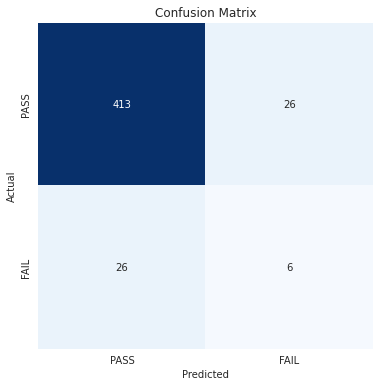

Classification Report:
----------------------
               precision    recall  f1-score   support

        PASS       0.94      0.94      0.94       439
        FAIL       0.19      0.19      0.19        32

    accuracy                           0.89       471
   macro avg       0.56      0.56      0.56       471
weighted avg       0.89      0.89      0.89       471



In [19]:
model = LogisticRegression()
model.fit(X_train, y_train)

evaluate_model(model, X_test, y_test)

# Random Oversampling

In [20]:
oversampler = RandomOverSampler(random_state=1)
X_train_os, y_train_os = oversampler.fit_resample(X_train, y_train)

In [21]:
y_train.value_counts()

PASS    1024
FAIL      72
Name: Pass/Fail, dtype: int64

In [22]:
fig = px.pie(
    y_train_os.value_counts(),
    values='Pass/Fail',
    names=["PASS", "FAIL"],
    title="Class Distribution",
    width=500
)

fig.show()

Accuracy: 86.62%


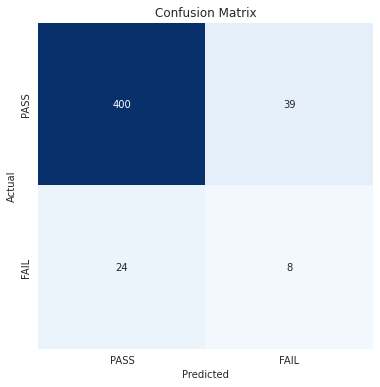

Classification Report:
----------------------
               precision    recall  f1-score   support

        PASS       0.94      0.91      0.93       439
        FAIL       0.17      0.25      0.20        32

    accuracy                           0.87       471
   macro avg       0.56      0.58      0.56       471
weighted avg       0.89      0.87      0.88       471



In [23]:
model = LogisticRegression()
model.fit(X_train_os, y_train_os)

evaluate_model(model, X_test, y_test)

# Oversampling With SMOTE

In [24]:
oversampler = SMOTE(random_state=1)
X_train_smote, y_train_smote = oversampler.fit_resample(X_train, y_train)

In [25]:
y_train_smote.value_counts()

PASS    1024
FAIL    1024
Name: Pass/Fail, dtype: int64

Accuracy: 85.77%


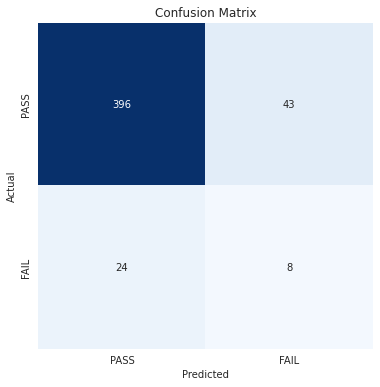

Classification Report:
----------------------
               precision    recall  f1-score   support

        PASS       0.94      0.90      0.92       439
        FAIL       0.16      0.25      0.19        32

    accuracy                           0.86       471
   macro avg       0.55      0.58      0.56       471
weighted avg       0.89      0.86      0.87       471



In [26]:
model = LogisticRegression()
model.fit(X_train_smote, y_train_smote)

evaluate_model(model, X_test, y_test)